### Steps for CNN of ASL Dataset

Load ASL training and test datasets 
- don't know how to process the image from individual pixels to torch or matplotlib
Define a Convolutional Neural Network
- working on understand different parts of torch architecture steps
Define a loss function
Train the network on the training data
Test the network on the test data

Visualize # of each letter in datasets(Bar graph to show samples in each class)
Randomly generate 1 sample from each class
Show correctly classified and wrongly classified to show why some are easier to classify vs harder to classify

#### Dataset Origin 
https://www.kaggle.com/datamunge/sign-language-mnist

#### Pytorch tutorial/inspiration
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [1]:
%matplotlib inline
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torch
import torch.nn as nn



In [2]:
df_test = pd.read_csv('./sign_mnist_test.csv')
df_train = pd.read_csv('./sign_mnist_train.csv')

In [3]:
df_train.head()
df_test.head()
print(df_train.shape)
print(df_test.shape)

(27455, 785)
(7172, 785)


In [4]:
df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [5]:
#separate labels (letter classes) from training data set
#drop label from rest of pixels
labels_train = df_train['label']
df_train = df_train.drop('label',axis = 1)

In [6]:
# #separate labels (letter classes) from test data set
#drop label from rest of pixels
labels_test = df_test['label']
df_test = df_test.drop('label',axis = 1)

### Data visualizations 
- visualize # of each letter in total dataset
- (randomly) generate sample
- more?

In [7]:
# create dataframe with all labels to make a bargraph
frames = [labels_train,labels_test]
df_all_labels = pd.concat(frames)
print(df_all_labels.shape)
df_all_labels.head()

(34627,)


0     3
1     6
2     2
3     2
4    13
Name: label, dtype: int64

[Text(0, 0.5, '# counts'), Text(0.5, 0, 'Alphabet Letters')]

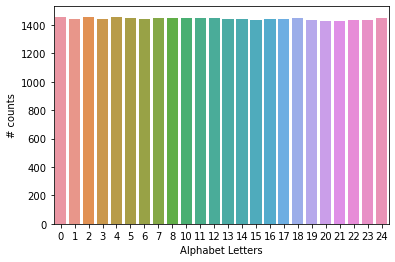

In [8]:
# create a bar graph with number of each labels
'''Want to change so that 0,1,2,3 etc reads A,B,C,D etc'''

ax = sns.barplot(x=df_all_labels.value_counts().index, y=df_all_labels.value_counts())
ax.set(ylabel = '# counts', xlabel = 'Alphabet Letters' )

In [9]:
df_all_labels.value_counts()

0     1457
4     1455
2     1454
5     1451
11    1450
8     1450
24    1450
12    1449
7     1449
18    1445
10    1445
16    1443
1     1442
14    1442
13    1442
3     1441
6     1438
17    1438
15    1435
19    1434
23    1431
22    1431
21    1428
20    1427
Name: label, dtype: int64

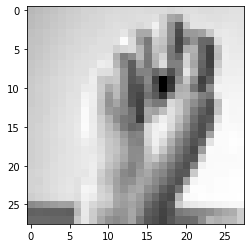

In [10]:
#convert each image to a 28x28 array
testimg = np.array(df_train[4:5]).reshape(28,28)
plt.imshow(testimg,cmap = 'gray')

In [11]:
# # from image processing tutorial
# def plot_image(image, color_map = None, title = None):
# #     raise NotImplementedError    # delete this line to write the function
#     plt.imshow(image, cmap = color_map)
#     plt.title(title)
#     plt.axis('off')
#     plt.show()

### Converting data to tensor

In [42]:
# convert pandas df to numpy array and reshape into 28x28 array as prep for picture
np_train = df_train.to_numpy() #training dataset
np_train = np_train.reshape(np_train.shape[0],28,28)
np_test = df_test.to_numpy() # testing dataset
np_test = np_test.reshape(np_test.shape[0],28,28)

Text(0.5, 0, '20')

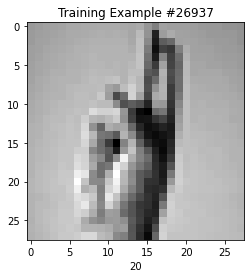

In [49]:
#show random image
random_image = random.randint(0,len(np_train))
plt.imshow(np_train[random_image], cmap = 'gray')
plt.title(f"Training Example #{random_image}")
plt.xlabel(labels_train[random_image]) #xlabel = letter of alphabet